# CS 363M Project: Car Accident Injury Prediction
### Names: Grace Choi, Eshi Kohli, Arul Yamdagni, Gregory Zachariah

## Introduction




Predicting injury severity in traffic collisions is important for increasing road safety and guiding policy decisions in traffic management. Accurate prediction of injury severity can help allocate emergency response resources more effectively, improve vehicle safety standards, and inform the public about risky behaviors and hazardous conditions. These predictions can provide future improvements on roadways and intersections based on patterns observed in collision data.

In this project, we will classify the injury severity of drivers involved in 92,433 traffic collisions in Montgomery County, MD. The dataset, provided by dataMontgomery on Data.gov, includes 38 features such as Collision Type, Weather, Driver Substance Abuse, Circumstance, Vehicle Damage Extent, Speed, and Vehicle Model. The dataset is available at https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Drivers-Data/mmzv-x632/data_preview 

We began by exploring the data before getting started on modeling. Our first step was to identify features that could help predict injury severity. We also evaluated the extent of missing values and the variance in each feature. This process allowed us to find the most relevant features, anticipate challenges, and develop a game plan on how to proceed.

In [36]:
# Imports
import pandas as pd
import numpy as np

# Feature Engineering
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Anomaly Detection
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict

# SVM
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# Neural Networks
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score

# K-Means
import random
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score

# DBSCAN
from sklearn.model_selection import StratifiedKFold
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN 
import dbcv


# Hierarchical Clustering
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import f1_score
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_samples  

To kick things off, let's first read our dataset into a dataframe.

In [8]:
# Read Data (standardize all n/a values)
df = pd.read_csv('Crash_Reporting_-_Drivers_Data_20241120.csv', na_values=['N/A','Unknown', 'UNKNOWN', 'Unknown, Unknown'])

/var/folders/5y/grltp88d5xbf4jg3zs0r6y9r0000gn/T/ipykernel_97442/3862745242.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Crash_Reporting_-_Drivers_Data_20241120.csv', na_values=['N/A','Unknown', 'UNKNOWN', 'Unknown, Unknown'])


## Preprocessing Data

### Data Cleaning

#### Deleting Columns

**Delete columns with information that is irrelevant to the prediction.**

We decided to drop `Report Number`, `Local Case Number`, `Person ID`, `VehicleID`, `Agency Name`, `Vehicle Make`, `Vehicle Going Dir`, `Route`, `Type` and `Cross-Street Name` as they were not relevant to our prediction of injury severity. Given that our data was sourced from one county in Maryland, information such as the street name and report number are hyper specific to a particular area and cannot be generalized when making predictions on our class label. 

**Delete columns with too many missing values.**

We also dropped `Municipality`, `Off-Road Description`, `Related Non-Motorist`, `Non-Motorist Substance Abuse`, and `Circumstance` due to their being a large number of missing values. Since these features are categorical with a large variety of potential values, imputation would not be effective.

**Delete columns due to other reasoning.**

Additionally, we dropped `Vehicle Model`, `Road Name`,  `Latitude`, and `Longitude` due to their values being too specific, making it difficult to find generalized trends between injury and non-injury. We removed `Parked Vehicle` since the value was also contained in our `Vehicle Movement feature`. `Off-Road Description` was removed due to the values being too specific and also having many missing values. Lastly, `Driverless Vehicle` and `Drivers License State` were removed as features due to there being little variance in the values and contributing little to our findings. 


In [34]:
# Delete columns
del_cols = ['Report Number', 'Local Case Number', 'Person ID', 'Vehicle ID', 'Agency Name',
            'Municipality', 'Off-Road Description', 'Latitude', 'Longitude', 'Vehicle Make', 
            'Vehicle Model', 'Vehicle Going Dir', 'Parked Vehicle', 'Related Non-Motorist', 
            'Non-Motorist Substance Abuse', 'Circumstance', 'Route Type', 'Road Name', 'Cross-Street Name', 
            'Off-Road Description', 'Driverless Vehicle', 'Drivers License State','Location']


# Delete columns that aren't useful/relevant
df = df.drop(columns=del_cols)

#### Missing Values
Before proceeding to data exploration, we wanted to make sure that we take care of missing values in our data. Since all features with missing values are categorical, imputation was not a suitable approach. Moreover, the number of missing values was relatively small compared to the total size of the dataset. Given the abundance of data available, we opted to drop rows with missing values, which also helped streamline our dataset. After dropping all these values, we retained about 49% of our original dataset. Despite this being a significant reduction, we still had a large amount of data points to work with (~92k).

In [35]:
null_data = df[df.isnull().any(axis=1)]
print("Num of Rows: ", len(df))
print("Rows with Missing Values", len(null_data))
# Missing/Null Values Dropped or Imputed

print("Missing Values:\n", df.isnull().sum())
# Justification written in cell above.
df = df.dropna()
print("New Num of Rows: ", len(df))

Num of Rows:  188090
Rows with Missing Values 95299
Missing Values:
 ACRS Report Type                     0
Crash Date/Time                      0
Collision Type                    1420
Weather                          14154
Surface Condition                22113
Light                             2177
Traffic Control                  27132
Driver Substance Abuse           44970
Driver At Fault                   4682
Injury Severity                    990
Driver Distracted By             37649
Vehicle Damage Extent             6936
Vehicle First Impact Location     3238
Vehicle Body Type                 3951
Vehicle Movement                  3730
Speed Limit                          0
Vehicle Year                         0
dtype: int64
New Num of Rows:  92791


Using 16 out of these 38 features as displayed above, we will attempt to predict the injury severity level, making this a supervised learning classification problem. Additionally, we will utilize unsupervised learning models to cluster the data and validate such clusterings through semi-supervised cluster validation.

### Feature Engineering & Data Exploration

In this section, we will approach the process of both data exploration and feature engineering iteratively, alternating between the two simultaneously. First, we will properly format features that would represent numerical data. We will then explore the various categorical values and group the corresponding feature values accordingly. We will then repeat this cycle of exploring the data and refining features while comparing class correlations, similarities, and imbalances until we achieve a well-prepared dataset for our analysis.

The following transformations were applied to preprocess and engineer features for the dataset:

1. **String Normalization**: Converted all string values to lowercase for consistency.
2. **Class Label Positioning**: Moved the `Injury Severity` column to the last position for clarity.
3. **Date Formatting**: Converted the `Crash Date/Time` column to datetime format and extracted the hour of occurrence.
4. **Feature Corrections**:
   - Simplified `Vehicle First Impact Location` by extracting the first word.
   - Removed rows with invalid or erroneous `Vehicle Year` values.
5. **Feature Consolidation**:
   - Merged similar categories for `Collision Type`, `Weather`, `Surface Condition`, `Light`, `Traffic Control`, `Driver Substance Abuse`, `Driver Distracted By`, `Vehicle Damage Extent`, `Vehicle Body Type`, `Vehicle Movement`, and `Injury Severity` into broader, more manageable groups using logical conditions.
6. **Error Handling**:
   - Dropped erroneous or redundant entries in features like `Vehicle Year` and consolidated noise/errors in other features.

We started our feature engineering by normalizing our strings and moving our class label to the last column of our dataframe

In [36]:
# Formatting
# Make sure all string values are lowercase 
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# Move class label to the end
df = df[[c for c in df if c not in 'Injury Severity'] + ['Injury Severity']]

The original data in the `Crash Date/Time` column was formatted as `m/D/Y H:M:S am/pm.` We concluded that the date information was irrelevant for predicting injury severity, but the time of day could hold significant importance. To reduce hyper-specificity and simplify the analysis, we binned the data by extracting the hour from each timestamp, converting it to military time to represent the true hour of the day. This approach allows for a more generalized understanding of time-related patterns without unnecessary granularity.

In [12]:
# Convert date to datetime
df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'], format='%m/%d/%Y %I:%M:%S %p')
df['Crash Date/Time'] = df['Crash Date/Time'].dt.hour


We standardized the `Vehicle First Impact Location` location, since the original recorded values were unorganized and had duplicates,  by extracting only the first word for consistency. 


In [13]:
# Correct values of Impact Location
df['Vehicle First Impact Location'] = df['Vehicle First Impact Location'].apply(lambda x: x.split()[0])


Additionally, invalid values in the `Vehicle Year` column, such as improbable years, were identified and removed to maintain data integrity and reliability. 


In [14]:
# Correct values of Vehicle Year
error_vals = [
    0, 99, 201, 2918, 215, 2996, 2917, 2040, 200, 202, 
    3013, 2914, 5005, 2911, 2201, 9999, 2099, 2208, 
    2200, 8, 198, 2919, 2055, 3003, 8008, 3863, 2912, 
    1008, 1025, 4, 2104, 1111, 1234, 1000, 2025, 3012, 2991
]

df = df.drop(df[df['Vehicle Year'].isin(error_vals)].index)

After parsing through our data with the features we wanted to include in our models, we found there were 262 dimensions if we were to one-hot encode all of our categorical features. To prevent our models from succumbing to the curse of dimensionality, we opted to first manually consolidate our dimensions before further reducing them with PCA. When exploring how to consolidate the different values for each of our features, we focused primarily on grouping values with similar meanings or similar environments. For instance, some features had similar values written differently with extra spacing or different ordering, adding to an increase in dimensions. After consolidating our data, we were able to reduce our data to 84 dimensions. 


### Feature Dimension Reduction

The following list displays the dimensions of features before and after consolidation:

- **Collision Type**: 24 → 7  
- **Weather**: 16 → 9  
- **Surface Condition**: 12 → 10  
- **Light**: 10 → 7  
- **Traffic Control**: 27 → 7  
- **Driver Substance Abuse**: 17 → 2  
- **Driver At Fault**: 2 → 2  
- **Driver Distracted By**: 21 → 3  
- **Vehicle Damage Extent**: 7 → 3  
- **Vehicle First Impact Location**: 30 → 18  
- **Vehicle Body Type**: 48 → 7  
- **Vehicle Movement**: 26 → 4  
- **Injury Severity**: 5 → 2  

**Collision Type Consolidation**

In [15]:
# Collision Type feature consolidation (breakdown on doc)
same_dir = [
    'same dir rear end', 'same direction right turn', 'same direction left turn', 'same dir rend right turn',
    'same dir rend left turn', 'same dir both left turn', 'front to rear'
]

opp_dir = [
    'head on', 'front to front', 'opposite dir both left turn'
]

angle = [
    'straight movement angle', 'head on left turn', 'angle meets left turn',
    'angle meets right turn', 'angle meets left head on', 'angle'
]

sideswipe = [
    'sideswipe, same direction', 'sideswipe, opposite direction',
    'same direction sideswipe', 'opposite direction sideswipe'
]


conditions = [
    df['Collision Type'].isin(same_dir),
    df['Collision Type'].isin(opp_dir),
    df['Collision Type'].isin(angle),
    df['Collision Type'].isin(sideswipe),
    df['Collision Type'].isin(['rear to side', 'rear to rear']),
    df['Collision Type'] == 'single vehicle'
]

outputs = [
    'same dir',
    'opposite dir',
    'angle',
    'sideswipe',
    'rear',
    'single vehicle'
]

# Consolidate Collision Type
df['Collision Type'] = np.select(conditions, outputs, default='other')

**Weather Consolidation**

In [16]:
conditions = [
    df['Weather'] == 'clear',
    df['Weather'].isin(['foggy', 'fog, smog, smoke']),
    df['Weather'].isin(['severe winds', 'severe crosswinds']),
    df['Weather'].isin(['raining', 'rain']),
    df['Weather'].isin(['wintry mix', 'blowing snow']),
    df['Weather'].isin(['freezing rain or freezing drizzle', 'sleet', 'sleet or hail']),
    df['Weather'].isin(['blowing sand, soil, dirt']),
    df['Weather'] == 'cloudy'
]

outputs = [
    'clear',
    'foggy',
    'windy',
    'rain',
    'snowy',
    'sleet or hail',
    'blowing sand, soil, dirt',
    'cloudy'
]

# Consolidate Weather
df['Weather'] = np.select(conditions, outputs, default='other')

**Surface Condition Consolidation**

In [17]:
conditions = [
    df['Surface Condition'] == 'dry',
    df['Surface Condition'].isin(['ice', 'ice/frost']),
    df['Surface Condition'] == 'wet',
    df['Surface Condition'] == 'slush',
    df['Surface Condition'].isin(['water(standing/moving)', 'water (standing/moving)']),
    df['Surface Condition'] == 'snow',
    df['Surface Condition'] == 'mud, dirt, gravel',
    df['Surface Condition'] == 'oil',
    df['Surface Condition'] == 'sand'
]

outputs = [
    'dry',
    'ice',
    'wet',
    'slush',
    'water',
    'snow',
    'mud, dirt, gravel',
    'oil',
    'sand'
]

# Consolidate Surface Condition
df['Surface Condition'] = np.select(conditions, outputs, default='other')


**Light Consolidation**


In [18]:
conditions = [
    df['Light'] == 'daylight',
    df['Light'].isin(['dark - unknown lighting', 'dark - unknown']),
    df['Light'].isin(['dark lights on', 'dark - lighted']),
    df['Light'].isin(['dark no lights', 'dark- not lighted']),
    df['Light'] == 'dusk',
    df['Light'] == 'dawn',
]

outputs = [
    'daylight',
    'dark',
    'dark lighted',
    'dark unlighted',
    'dusk',
    'dawn'
]

# Consolidate Light
df['Light'] = np.select(conditions, outputs, default='other')

**Traffic Control Consolidation**


In [19]:
traffic_signal = [
    'traffic signal', 'flashing traffic signal', 'traffic control signal',
    'flashing traffic control signal', 'other signal', 'lane use control signal',
    'ramp meter signal', 'school zone sign device', 'flashing railroad crossing signal (may include gates)'
]

yield_sign = [
    'yield sign', 'pedestrian crossing sign', 'pedestrian crossing', 'school zone sign', 
    'bicycle crossing sign', 'school zone'
]

person = [
    'person', 'person(including flagger, law enforcement, crossing guard, etc.)'
]

warning = [
    'warning sign', 'other warning sign', 'reduce speed ahead warning sign', 
    'curve ahead warning sign', 'railway crossing device', 'intersection ahead warning sign'
]

conditions = [
    df['Traffic Control'] == 'no controls',
    df['Traffic Control'].isin(traffic_signal),
    df['Traffic Control'] == 'stop sign',
    df['Traffic Control'].isin(yield_sign),
    df['Traffic Control'].isin(person),
    df['Traffic Control'].isin(warning)
]

outputs = [
    'no controls',
    'traffic signal',
    'stop sign',
    'yield sign',
    'person',
    'warning'
]

# Consolidate Traffic Control
df['Traffic Control'] = np.select(conditions, outputs, default='other')

**Substance Abuse Consolidation**


In [20]:
no_substance_abuse = [
    'none detected',
    'not suspect of alcohol use, not suspect of drug use',
]
df['Driver Substance Abuse'] = np.where(df['Driver Substance Abuse'].isin(no_substance_abuse), 'no', 'yes')

**Driver Distracted By Consolidation**


In [21]:
distracted_hands_on_wheel = [
    'talking or listening to cellular phone',
    'distracted by outside person object or event',
    'by other occupants',
    'other action (looking away from task, etc.)',
    'talking/listening',
    'looked but did not see',
    'inattentive or lost in thought',
    'other distraction',
    'no driver present',
    'smoking related',
    'manually operating (dialing, playing game, etc.)'
]

distracted_hands_off_wheel = [
    'other electronic device (navigational palm pilot)',
    'other cellular phone related',
    'using other device controls integral to vehicle',
    'dialing cellular phone',
    'manually operating (dialing, playing game, etc.)',
    'texting from a cellular phone', 
    'using device object brought into vehicle',
    'eating or drinking',
    'by moving object in vehicle',
    'adjusting audio and or climate controls',
]

conditions = [
    df['Driver Distracted By'].isin(distracted_hands_on_wheel),
    df['Driver Distracted By'].isin(distracted_hands_off_wheel)
]


outputs = [
    'distracted - both hands on wheel',
    'distracted - hands not on wheel'
]

# Consolidate driver distracted by 
df['Driver Distracted By'] = np.select(conditions, outputs, default='not distracted')


**Vehicle Damage Extent Consolidation**


In [22]:
conditions = [
    df['Vehicle Damage Extent'].isin(['disabling', 'destroyed']),
    df['Vehicle Damage Extent'].isin(['superficial','no damage', 'functional','vehicle not at scene'])
]

outputs = [
    'significant',
    'not significant'
]

# Consolidate Vehicle Damage Extent
df['Vehicle Damage Extent'] = np.select(conditions, outputs, default='other')


**Vehicle Body Type Consolidation**


In [23]:
car = [
    'passenger car', '(sport) utility vehicle', 'sport utility vehicle', 'pickup', 'pickup truck', 'station wagon'
    
]

bike = [
    'motorcycle - 2 wheeled', 'moped or motorized bicycle', 'motorcycle - 3 wheeled', 'motorcycle', 'moped'
]

van = [
    'van', 'van - passenger (&lt;9 seats)', 'van - passenger (15 seats)', 'van - cargo'
]

bus = [
    'bus - mini', 'bus - cross country', 'transit bus', 'school bus', 'other bus',
    'bus - other type', 'bus - school', 'bus - transit', 'cross country bus'
]

truck = [
    'truck tractor', 'single-unit truck', 'other trucks',
    'other light trucks (10,000lbs (4,536kg) or less)', 
    'cargo van/light truck 2 axles (over 10,000lbs (4,536 kg))',
    'medium/heavy trucks 3 axles (over 10,000lbs (4,536kg))',
    'recreational vehicle', 'recreational off-highway vehicles (rov)'
]

emergency = [
    'fire vehicle/non emergency', 'ambulance/emergency', 'fire vehicle/emergency',
    'police vehicle/non emergency', 'ambulance/non emergency', 'police vehicle/emergency'
]


conditions = [
    df['Vehicle Body Type'].isin(car),
    df['Vehicle Body Type'].isin(bike),
    df['Vehicle Body Type'].isin(van),
    df['Vehicle Body Type'].isin(bus),
    df['Vehicle Body Type'].isin(truck),
    df['Vehicle Body Type'].isin(emergency)
]

outputs = [
    'car',
    'bike',
    'van',
    'bus',
    'truck',
    'emergency'
]

# Consolidate Vehicle Body Type
df['Vehicle Body Type'] = np.select(conditions, outputs, default='misc')


**Vehicle Movement Consolidation**


In [24]:
turning = [
    'making u-turn', 'turning left', 'negotiating a curve', 'right turn on red',
    'making left turn', 'making right turn', 'making u turn', 'turning right'
]

parking_stopped = [
    'parked', 'parking', 'starting from parked', 'slowing or stopping',
    'stopped in traffic', 'stopped in traffic lane'
]

moving = [
    'moving constant speed', 'passing', 'overtaking/passing', 'skidding',
    'accelerating', 'changing lanes', 'driverless moving veh.', 'backing',
    'leaving traffic lane', 'entering traffic lane', 'starting from lane'
]

conditions = [
    df['Vehicle Movement'].isin(turning),
    df['Vehicle Movement'].isin(parking_stopped),
    df['Vehicle Movement'].isin(moving),
]

outputs = [
    'turning',
    'parking/stopped',
    'moving'
]

# Consolidate Vehicle Movement
df['Vehicle Movement'] = np.select(conditions, outputs, default='other')

**Injury Severity Consolidation (Class Label)**


In [25]:
conditions = [
    df['Injury Severity'].isin(['suspected minor injury', 'possible injury', 'suspected serious injury', 'fatal injury']),
    df['Injury Severity'] == 'no apparent injury'
]

outputs = [
    'injury',
    'no injury'
]

# Consolidate Injury Severity (Class)
df['Injury Severity'] = np.select(conditions, outputs)

### Feature Engineering 

To prepare our data for our models, we worked on one-hot encoding our categorical variables, separating features from labels, and analyzing the dataset's structure. Categorical columns, such as `Collision Type`, `Weather`, `Vehicle Body Type`, `Light`, `Driver Distracted By`, `Vehicle Movement`, `Vehicle Damage Extent`, `Vehicle First Impact Location`, `Surface Condition`, `Traffic Control`, and `ACRS Report Type`, were transformed using one-hot encoding to convert them into binary columns. Binary columns like `Driver At Fault`, `Driver Substance Abuse`, and `Injury Severity` are also one-hot encoded with one category dropped to prevent multicollinearity.

Our target variable, `Injury Severity_no injury`, was extracted and reshaped into a 1D array, leaving the remaining columns as features. 


In [51]:
# One Hot Encoding
OHE_multi_cols = ['Collision Type', 'Weather', 'Vehicle Body Type', 'Light', 
                  'Driver Distracted By', 'Vehicle Movement', 'Vehicle Damage Extent',
                  'Vehicle First Impact Location', 'Surface Condition', 'Traffic Control', 'ACRS Report Type']
OHE_binary_cols = ['Driver At Fault', 'Driver Substance Abuse', 'Injury Severity']

df = pd.get_dummies(df, columns=OHE_multi_cols)
df = pd.get_dummies(df, columns=OHE_binary_cols, drop_first=True)

# Separate features from labels
feature_data = df.drop('Injury Severity_no injury', axis=1)
label_data = df['Injury Severity_no injury']
label_data = label_data.values.ravel()

for col in df.columns:
    print(col, df[col].unique(), df[col].nunique())

print(df.shape)
print(df.head)

print(feature_data.shape)
print(df.shape)

Crash Date/Time [11 12 20 19 10 18  8 14 15 16  9 13 17  7  1  0 21 22  5  6  2 23  3  4] 24
Speed Limit [30 35 15 40  5  0 55 45 25 20 50 65 10 60 75 70] 16
Vehicle Year [2010 2022 2016 2021 2002 2007 2017 2012 2015 2006 2014 2000 2009 2023
 2013 2020 2011 2018 2008 1997 2019 1999 2005 2003 1998 2004 1995 1991
 1984 2001 2024 1992 1993 1996 1994 1989 1987 1981 1990 1966 1988 1969
 1986 1975 1985 1968 1972 1960 1970 1938 1949 1982 1980 1971 1983 1961
 1978 1947 1955 1974 1977 1963 1976 1979 1959 1900] 66
Collision Type_angle [False  True] 2
Collision Type_opposite dir [False  True] 2
Collision Type_other [False  True] 2
Collision Type_rear [False  True] 2
Collision Type_same dir [ True False] 2
Collision Type_sideswipe [False  True] 2
Collision Type_single vehicle [False  True] 2
Weather_blowing sand, soil, dirt [False  True] 2
Weather_clear [False  True] 2
Weather_cloudy [ True False] 2
Weather_foggy [False  True] 2
Weather_other [False  True] 2
Weather_rain [False  True] 2
Weather_sl

#### Feature Engineering and Correlation
To determine if we could remove or combine any redundant, highly correlated features to mitigate for the curse of dimensionality in our dataset, we plotted the correlation matrix between all features. We found that most features shared a low positive or negative correlation with each other, so we decided to not add or remove any features at this point in our project.

[Text(0.5, 0, 'Crash Date/Time'),
 Text(3.5, 0, 'Collision Type_angle'),
 Text(6.5, 0, 'Collision Type_rear'),
 Text(9.5, 0, 'Collision Type_single vehicle'),
 Text(12.5, 0, 'Weather_cloudy'),
 Text(15.5, 0, 'Weather_rain'),
 Text(18.5, 0, 'Weather_windy'),
 Text(21.5, 0, 'Vehicle Body Type_car'),
 Text(24.5, 0, 'Vehicle Body Type_truck'),
 Text(27.5, 0, 'Light_dark lighted'),
 Text(30.5, 0, 'Light_daylight'),
 Text(33.5, 0, 'Driver Distracted By_distracted - both hands on wheel'),
 Text(36.5, 0, 'Vehicle Movement_moving'),
 Text(39.5, 0, 'Vehicle Movement_turning'),
 Text(42.5, 0, 'Vehicle Damage Extent_significant'),
 Text(45.5, 0, 'Vehicle First Impact Location_eleven'),
 Text(48.5, 0, 'Vehicle First Impact Location_nine'),
 Text(51.5, 0, 'Vehicle First Impact Location_roof'),
 Text(54.5, 0, 'Vehicle First Impact Location_ten'),
 Text(57.5, 0, 'Vehicle First Impact Location_twelve'),
 Text(60.5, 0, 'Vehicle First Impact Location_vehicle'),
 Text(63.5, 0, 'Surface Condition_mud, dirt

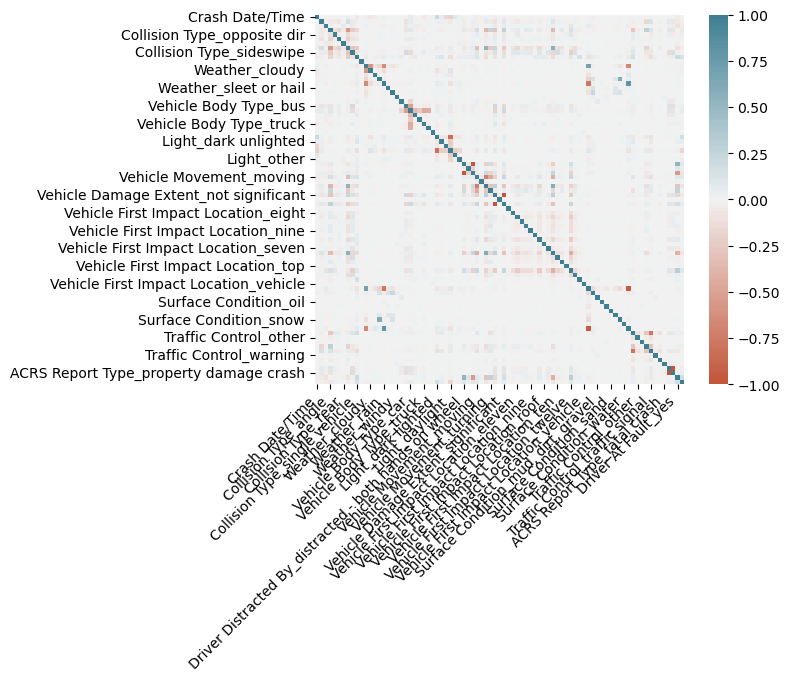

In [52]:
# Plot correlation between features.
ax = sns.heatmap(
    feature_data.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


### Anomaly Detection

We wanted to implement anomaly detection to identify and isolate unusual data points that deviate significantly from the rest of the dataset to ensure that outliers don't skew any of our model training and analysis. 

#### Algorithms Used
1. **Elliptic Envelope**  
   - Fits a Gaussian distribution to the data.  
   - Detects outliers based on the Mahalanobis distance.  

2. **Isolation Forest**  
   - Detects anomalies by isolating instances using random partitioning.  

3. **Local Outlier Factor (LOF)**  
   - Identifies anomalies by comparing the local density of a data point with its neighbors.  

4. **One-Class SVM**  
   - Uses a Support Vector Machine with a radial basis function kernel.  
   - Separates normal instances from anomalies.  

#### Implementation
- Each method is configured with a contamination rate of 25%, representing the expected proportion of anomalies in the dataset.  
- Predictions from each algorithm are stored in the `pred_list` which we then used to remove the anomaly points from our dataframe

In [28]:
pred_list = []

#EllipticEnvelope AD
envelope_pred = EllipticEnvelope(contamination=0.25).fit_predict(feature_data)
pred_list.append(envelope_pred)

#IsolationForest AD
forest_pred = IsolationForest(contamination=0.25).fit_predict(feature_data)
pred_list.append(forest_pred)

#LocalOutlierFactor AD
lof_pred = LocalOutlierFactor(contamination=0.25).fit_predict(feature_data)
pred_list.append(lof_pred)

# #OneClassSVM AD
svm_pred = OneClassSVM(kernel='rbf', nu=0.25).fit_predict(feature_data)
pred_list.append(svm_pred)
 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


#### Interpretation of Anomaly Detection

- **Dataset Size:** Initially, the dataset contained **92,703 data points** after removing rows with missing values. After applying anomaly detection, the subset of points remaining was reduced to **38,975**, with 84 features considered.  
- **Target Feature Analysis:** For the feature `Injury Severity_no injury`:  
  - Out of the remaining data points, **30,545** were classified as `True` (non-anomalous instances).  
  - **8,430** were classified as `False` (potential anomalies or rare cases).  


In [54]:
# Drop anomalous rows
features_with_predictions = df.copy()
features_with_predictions['Anomaly_EllipticEnvelope'] = envelope_pred
features_with_predictions['Anomaly_IsolationForest'] = forest_pred
features_with_predictions['Anomaly_LocalOutlierFactor'] = lof_pred
features_with_predictions['Anomaly_OneClassSVM'] = svm_pred

# Drop rows where any method flagged them as anomalous (-1)
filtered_features = features_with_predictions[
    (features_with_predictions['Anomaly_EllipticEnvelope'] != -1) &
    (features_with_predictions['Anomaly_IsolationForest'] != -1) &
    (features_with_predictions['Anomaly_LocalOutlierFactor'] != -1) & 
    (features_with_predictions['Anomaly_OneClassSVM'] != -1)
]

# Optional: Drop the anomaly columns from the filtered dataset

df = filtered_features.drop(columns=['Anomaly_EllipticEnvelope', 'Anomaly_IsolationForest', 'Anomaly_LocalOutlierFactor', 'Anomaly_OneClassSVM'])

### PCA & Class Label Separation

Since we moved our anomalies, we can now proceed with our fully cleaned data. We updated our two separate dataframes to use in our future model work - one for our features and one for our class label.

We applied PCA to address the large number of dimensions in our dataset. First, we standardized the features using StandardScaler to ensure each feature had a mean of 0 and a standard deviation of 1. We then used PCA with the n_components=0.95 parameter, which retained at least 95% of the original variance, lowering the total dimensions to 65. The transformed data was then stored in a DataFrame for further analysis. This dimensionality reduction improved model performance by focusing on the most significant features and reducing the computational complexity.

We realized that our dataset exhibits significant class imbalance. ‘No injury’ and ‘Injury’ are represented by 30,545 and 8,430 records respectively. When comparing these two labels,’ the latter only makes up 21.6% of the data. This imbalance can make model training challenging, since classifiers may become biased toward the majority classes. This could reduce their ability to accurately predict the minority class. Addressing this issue may require techniques such as resampling, reweighting, or employing algorithms designed to handle imbalanced data effectively.


In [55]:
# Separate features from labels
feature_data = df.drop('Injury Severity_no injury', axis=1)
label_data = df['Injury Severity_no injury']
label_data = label_data.values.ravel()

print(df.shape)
print(df['Injury Severity_no injury'].value_counts())


# Scaling
# PCA to decide number of dimensions
scaler = StandardScaler()
scaled_data = scaler.fit_transform(feature_data)
pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(scaled_data)
pca_data = DataFrame(pca_data)

(37231, 84)
Injury Severity_no injury
True     28674
False     8557
Name: count, dtype: int64


## Modeling: Supervised

### Decision Trees

As decision trees don't succumb to the the curse of dimensionality, we opted to try a decision tree model to predict injury severity. Given that decision trees are computationally inexpensive, the large size of our cleaned dataset seemed suitable for this classifier. In fine-tuning our decision tree algorithm, we made our impurity metric a hyperparameter along with other parameters in order to find the optimal model.

In [12]:

# Remove class label to prevent data leakage
X = df.drop(columns=["Injury Severity_no injury"])
y = df['Injury Severity_no injury'].astype(int)

# X = pca_data
# y = label_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

decisionTree = DecisionTreeClassifier()

We performed hyperparameter tuning for our Decision Tree model utilizing a GridSearchCV. Through a 5-fold cross validation, we tested various combination of parameters pertaining to the tree depth and minimum items needed to be a leaf node. Given that our data contained a clear class imbalance, we wanted to attempt using class_weight as a parameter to see if fixing our class imbalance would improve our accuracy results. 

In the instance of "class_weight: balanced", the class with fewer samples (injury) is weighted higher and thus has a more important emphasis during training while the dominance of overrepresented samples (no injury) are reduced in the training process. 

In [13]:
# Hyperparameters 
param_grid = {
    'max_depth': [5, 10, 15, 20, None], # Depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],      # Minimum samples to be a leaf node
    'class_weight': [None, 'balanced'], # Handle class imbalance
    'criterion': ['gini', "entropy"]    # Impurity Metric
}

# Doing 5-fold CV with hyperparameters (n_jobs=-1 uses all cores so it runs faster)
grid_search = GridSearchCV(estimator=decisionTree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


# Access the grid search results
results = grid_search.cv_results_


# Retrieve the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print mean test scores for each parameter combination
print("Accuracy scores for different parameter values:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Params: {params}, Accuracy: {mean_score:.4f}")

# Test the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")


Accuracy scores for different parameter values:
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}, Accuracy: 0.8597
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}, Accuracy: 0.8597
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}, Accuracy: 0.8597
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}, Accuracy: 0.8598
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}, Accuracy: 0.8598
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}, Accuracy: 0.8598
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}, Accuracy: 0.8598
Params: {'class_wei

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Our decision tree model achieve an 86.62% accuracy in detecting injury, showing that it generalizes well to new data. It was interesting to see that the model with the 'class_weight: None' parameter performed sligtly better than the 'class_weight: balanced' model, suggesting that the class distributions in the dataset did not require balancing. We can infer this might likely be due to the sheer dominance of the 'no-injury' class label, causing the model to more correctly detect 'no-injury' by chance as it is more common in our dataset. However, the use of a max_depth of 5 prevents the model from exhibiting this overfitting behavior. 

Despite this, we wanted to assess the model's performance more in-depth with a confusion matrix to better understand how the class imbalance was influencing the model's predictions.

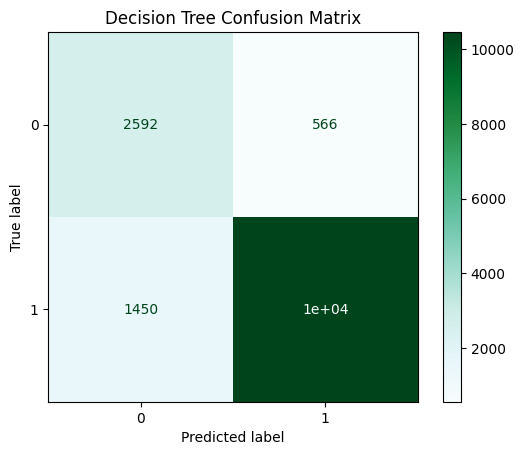

Confusion Matrix:
[[ 2592   566]
 [ 1450 10457]]


In [14]:
# Make confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display results from matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.BuGn)  # Use a blue colormap for better visualization
plt.title("Decision Tree Confusion Matrix")
plt.show()

print("Confusion Matrix:")
print(cm)


Before interpreting our confusion matrix, it's important to note that our class label column is 'Injury Severity_no injury' after doing one-hot encoding, so a true positive would indicate an accident being correctly identified as 'no injury'.

From the confuson matrix we can see:
Our sensitivity (TPR - correctly identified as no injury) was: 0.872
Our specificity (TNR - correctly identified as injury) was: 0.818

Since there is a class imbalance, we will find the precision and recall values for the rarer class (injury).

Precision(-): 0.633

Recall(-): 0.818

We can see here that given an 'injury' prediction from the decision tree, it is only 63% likely to be correct. This could be problematic especially in applications where a false negative (predicted injury incorrectly) could lead to unncessarily dispatching EMS units to an accident. We have a higher recall value of 0.818, meanign that the model will be more likely to detect an 'injury' prediction when it is present. 

While the model is successful at detecting "no injury" cases, its ability to predict "injury" cases needs improvement. Although, the high recall rate for "injury" ensures that most actualy injury cases are detected. 

### KNN

Given the performance of or decision tree model, we observed promising results for detecting cases of "no injury" from an accident. However, the model's lower precision in detecting "injury" and its tendency to misclassify some injury cases highlights areas for potential improvement. With this in mind, we wanted to explore how a KNN model would perform on our dataset. We were aware KNN is no necessarily the best model for handling class imbalanced as it prefers to favor the majority class, making predictions on the nearest neighbors without considering class distribution. 

However, we believe that by adjusing the weights parameter in KNN, we can mitigate this issue. Using the 'distance' weight option, we intend to give more importance to neighbors that are closer to a query point which could be beneficial in getting the model to better detect the "injury" class. Although KNN is no inherently suited for class imbalance, we were interested in seeing if the use of hyperparameters could make it more effective than decision trees.

In [15]:
# Prepare the data
data_X = df.drop(columns=["Injury Severity_no injury"])
data_Y = df['Injury Severity_no injury'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=42)

# Create pipeline and do scaling, PCA, and KNN
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver='full')
neighbors = KNeighborsClassifier(n_neighbors=7, weights='distance')

pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('knn', neighbors)])

# Set up the grid search with parameter grid
param_grid = {
    'pca__n_components': [8, 10, 15],  # Number of dimensions to keep after pca
    'knn__n_neighbors': [10, 25, 50, 100],  # Number of neighbors to consider when making a prediction for a point
    'knn__weights': ['uniform', 'distance'] # Weigh neighbors differently to combat class imbalance issues
}

# Initialize GridSearchCV with verbose output
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=10)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best parameters and accuracy
print("Best parameters:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_ * 100)

y_pred = grid_search.best_estimator_.predict(X_test)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 2/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 3/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 4/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 5/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 1/5; 2/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=10
[CV 2/5; 2/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=10
[CV 3/5; 2/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=10
[CV 3/5; 1/24] END knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8;, score=0.854 total time=   4.1s
[CV 4/5; 2/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=10
[CV 2/5; 1/24] END knn__n_neighbors=10, knn__weights=uniform, p

Interpreting our results, we can see our model achieved an accuracy of 85.62%. The optimal number of neighbors turned out to be 25, sugesting that the model performs best when it looks at a relatively larger neighborhood to make a decision, which could be useful in balancing the influence of outliers and noise. 

With unfirom weighting, the model does not prioritize closer nieghbors, treating all neighbors equally. Within the context of the class imbalance we faced with out dataset, this individates that minority class points may not be adequately prioritized, resulting in a lower recall for "injury" and a higher precision for the majority class. 

To better understand how our KNN model distinguishes between two classes, we used a classification report to evalute its performance on the entire dataset.

In [16]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      3158
           1       0.92      0.90      0.91     11907

    accuracy                           0.86     15065
   macro avg       0.79      0.81      0.80     15065
weighted avg       0.87      0.86      0.86     15065



We can see that our KNN model performed comparably to our decision tree, with 65% of 'injury' instances being predicted correctly. The recall(-) suggests a similar effectiveness as our decision tree in identifying 80% of all 'injury' cases. Similar to our decision tree, the KNN model performed well in identifying 'no injury' cases and avoiding false positives. Overall, the accuracy of our KNN slightly outperforms our decision tree with an 86% accuracy. However, we must view this high accuracy in the context of the class imbalance existing in our dataset. We tried to balance our classes using SMOTE and got the following results:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)


# Resample training data (will generate synthetic data points for 'injury class)
X_train_resampled, y__train_resampled = smote.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=10)
grid_search.fit(X_train_resampled, y__train_resampled)

print("Best parameters:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_ * 100)

# Evaluate the model on the original test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Get the classification report
print(classification_report(y_test, y_pred))



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 2/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 3/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 4/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 5/5; 1/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=8
[CV 1/5; 2/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=10
[CV 2/5; 2/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=10
[CV 3/5; 2/24] START knn__n_neighbors=10, knn__weights=uniform, pca__n_components=10
[CV 2/5; 1/24] END knn__n_neighbors=10, knn__weights=uniform, pca__n_comp

The results from balancing our training set using SMOTE show a dramatic improvement in the performance of our KNN Model. The accuracy increased slightly to 89.6% butand the precision for 'injury' decreased from 0.65 to 0.51, meaning our model is incorrectly labeling 'non-injury' cases as 'injury' slightly more often. This is a common side-effect of SMOTE since the auto balancing has a tendency to increase false positives as we oversample the minority ('injury') class. 

The recall for our SMOTE KNN, is significantly impoved from 0.72 to 0.82, suggesting that balancing our data made the model better at detecting more injusry cases and missing fewer instances of them. This lead us the see that the SMOTE model is identifying more injury cases than it did with our KNN using the imbalanced data. A higher recall is critical in a real-life scenario where its's important to detect all cases of an 'injury' from a car accident even if it's at the cost of some false positives, making our improvement in recall more significant than the decrease we witnessed in precision.  

Overall, our KNN model utilizing SMOTE for addressing our class imbalance showed promising results, demostrating that balancing the dataset improved the model's ability to detect 'injury' at the cost of precision. However, this trade-off is to be expected given the makeup of our original data. 

### Naive Bayes

We applied Gaussian Naive Bayes with 10-fold cross-validation to classify injury severity in the dataset. Although we were aware of the class imbalance in our data set, we still wanted to give this model a try because it's not susceptible to the curse of dimensionality. We also thought this model could be a good choice since our features are weakly correlated, and Naive Bayes assumes that the features used in classification are independent of each other.

In [57]:
# Run 10-fold cross-validation and print the accuracy
gnb = GaussianNB()
accuracies = cross_val_score(gnb, feature_data, label_data, cv=10)
avg_accuracy = accuracies.mean()
print("Accuracy:", (avg_accuracy * 100))

# Print the confusion matrix
predictions = cross_val_predict(gnb, feature_data, label_data, cv = 10)
print(confusion_matrix(label_data, predictions))
print(classification_report(label_data, predictions))

Accuracy: 79.20011912479484
[[ 8317   240]
 [ 7504 21170]]
              precision    recall  f1-score   support

       False       0.53      0.97      0.68      8557
        True       0.99      0.74      0.85     28674

    accuracy                           0.79     37231
   macro avg       0.76      0.86      0.76     37231
weighted avg       0.88      0.79      0.81     37231



The model has an overall accuracy of 79.2%. This shows that the model achieves solid accuracy with its predictions. However, this doesn't provide a complete picture. 

Let's take a look at the confusion matrix:
- True Positives: 21170 instances of the "true" class were correctly classified as true.
- False Positives: 240 instances of the "false" class were incorrectly classified as true.
- True Negatives: 8317 instances of the "false" class were correctly classified as false.
- False Negatives: 7504 instances of the "true" class were incorrectly classified as false.

The imbalance in false positives and false negatives suggests that the model has a stronger tendency to correctly classify the "true" class. This is due to the significant class imbalance. There are 28674 instances o the "true" class but only 8,557 instances of the "false" class. The model has more "true" class data to learn from, so it makes fewer false predicions for this class. We also see that the precision value is 0.53 for the "false" class. This means the model correctly predicts "false" 53% of the time but still misclassifies "false" as "true" a significant amount. 

Although Naive Bayes is efficient and works well with large datasets, it falls victim to the classic class imbalance problem. This imbalance leads to an overfitting to the "true" class and less effective classification of the minority "false" class.

### SVM
Since we are using binary classification, SVM was another model we wanted to test with our data. SVMs help find optimal decision boundaries between classes through kernel functions that trasnform the data. Considering we have multi-dimensional data, we felt using the Radial Basis Function (RBF) kernel would be best. It handles non-linearity in the relationships between features by mapping them into a higher dimensional space where these complex relationships can be linearly separated. This would make it possible to achieve more accurate classifications as apposed to using a linear kernel. The RBF kernel is also able to adapt to various data distributions without prior specification.

Since the issue of class imbalance persists, we used the stratify parameter while splitting the data in to training and test sets to help mitigate this problem. Passing the label data into the stratify parameter ensures that both the training and test datasets reflect the proportion of the classes in the original dataset. 

In [8]:
# SVM
label_data = df['Injury Severity_no injury']
feature_data = df.drop('Injury Severity_no injury', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, stratify=label_data, random_state=42)

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train SVM with RBF kernel
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_pca, y_train)

predictions = svm.predict(X_test_pca)

# Cross-validation predictions for full dataset 
cv_predictions = cross_val_predict(svm, pca.fit_transform(scaler.fit_transform(feature_data)), label_data, cv=10)

# Print classification reports
print("Test Set Report:")
print(classification_report(y_test, predictions))
print("Test Set Confusion Matrix:")
test_cm = confusion_matrix(y_test, predictions)
print(test_cm)

print("Cross-Validation Report:")
print(classification_report(label_data, cv_predictions))
print("Cross Validation Confusion Matrix:")
cv_cm = confusion_matrix(label_data, cv_predictions)
print(cv_cm)

Test Set Report:
              precision    recall  f1-score   support

       False       0.64      0.80      0.71      2160
        True       0.94      0.87      0.90      7500

    accuracy                           0.85      9660
   macro avg       0.79      0.84      0.81      9660
weighted avg       0.87      0.85      0.86      9660

Test Set Confusion Matrix:
[[1733  427]
 [ 975 6525]]
Cross-Validation Report:
              precision    recall  f1-score   support

       False       0.63      0.81      0.71      8639
        True       0.94      0.87      0.90     29999

    accuracy                           0.85     38638
   macro avg       0.79      0.84      0.81     38638
weighted avg       0.87      0.85      0.86     38638

Cross Validation Confusion Matrix:
[[ 7015  1624]
 [ 4047 25952]]


The reports from both the test set and the cross validation show almost identical results. The model achieved an accuracy of 85%. While this is seemingly high value, it is important to analyze the other values presented to us because of the issue of class imbalance. 

The model shows high precision for the class being True (no injury) at 94%, which indicates that when it predicts no injury, it is correct most of the time. However, when the class is False (injury), the precision is lower at 64%. This suggests a higher number of false positives, meaning the model would be predicting injury when there is none. We can see this reflected in the confusion matrix.

The recall values for both classes are relatively close. This shows that the model is fairly consistent in identifying both no injury and injury cases, meaning the model is generally good at capturing the majority of the true positives for each class.

Looking at the combination of precision and recall, the F1-Score, there is a noticeable difference between no injury and injury. The high score for no injury compared to the lower score for injury further proves that the model performs better in predicting no injuries than injuries. These results make sense due to the class imbalance. 

Further tuning of the SVM hyperparameters, such as C, could potentially help balance the recall and precision. Experimenting with different sampling strategies could also help address class imbalance more effectively. We can can balance the data using SMOTE, the same way we did with the KNN model.

In [31]:
# SVM with SMOTE
label_data = df['Injury Severity_no injury']
feature_data = df.drop('Injury Severity_no injury', axis=1)

# Split the data into training and test sets and resample data with SMOTE
X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, stratify=label_data, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # Apply SMOTE to training data

# Scale the features
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# PCA 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train SVM with RBF kernel
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_pca, y_train_resampled)

predictions = svm.predict(X_test_pca)

# Cross-validation predictions for full dataset 
cv_predictions = cross_val_predict(svm, pca.fit_transform(scaler.fit_transform(feature_data)), label_data, cv=10)

# Print classification reports
print("Test Set Report:")
print(classification_report(y_test, predictions))
print("Test Set Confusion Matrix:")
test_cm = confusion_matrix(y_test, predictions)
print(test_cm)

print("Cross-Validation Report:")
print(classification_report(label_data, cv_predictions))
print("Cross Validation Confusion Matrix:")
cv_cm = confusion_matrix(label_data, cv_predictions)
print(cv_cm)

Test Set Report:
              precision    recall  f1-score   support

       False       0.61      0.90      0.72      2121
        True       0.97      0.84      0.90      7616

    accuracy                           0.85      9737
   macro avg       0.79      0.87      0.81      9737
weighted avg       0.89      0.85      0.86      9737

Test Set Confusion Matrix:
[[1912  209]
 [1245 6371]]
Cross-Validation Report:
              precision    recall  f1-score   support

       False       0.64      0.81      0.71      8483
        True       0.94      0.87      0.91     30464

    accuracy                           0.86     38947
   macro avg       0.79      0.84      0.81     38947
weighted avg       0.88      0.86      0.86     38947

Cross Validation Confusion Matrix:
[[ 6901  1582]
 [ 3921 26543]]


Suprisingly, there was practically no improvement of the model after sampling the data using SMOTE to try to overcome class imbalance issues. While recall for injury did increase ~10%, the precision and f1-score still imply that the model is resulting in a higher number of false positives and that it is still performing better at predicting no injuries versus injuries. For further exploration, perhaps a different sampling technique would achieve better results than SMOTE, or editing the hyperparameters of SMOTE would be beneficial.

### Neural Nets
Next, we wanted to consider multi-layer perceptron neural networks since they are useful for representing the non-linear relationships in multi-dimensional data. To determine the optimal network configuration, we experimented with varying the number of nodes and layers. For the purposes of balancing training time and model complexity, we limited our configurations to a maximum of three hidden layers, with each layer containing between 30 to 50 nodes. This range was strategically chosen to prevent the model from becoming too general with too few nodes, while avoiding overfitting that might occur with a node count approaching the total number of features.

The activation functions we are testing with are standard and popular as activation function choices when training neural networks.

In [12]:
# Neural Nets
scaler = StandardScaler()
neuralnet = MLPClassifier()

# Pipeline of scaling data and training neural network
pipeline = Pipeline(steps=[('scaler', scaler), ('neuralnet', neuralnet)])

# Testing different network hidden layer configurations and activation functions
param_grid = {
    'neuralnet__hidden_layer_sizes': [(30,), (40,), (50,), (40, 30), (50, 40), (50, 30), (50, 40, 30)],
    'neuralnet__activation': ['logistic', 'tanh', 'relu']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(feature_data, label_data)

# Cross validation
scores = cross_val_score(grid_search, feature_data, label_data, cv=5)

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Eshi/opt/anaconda3/li

Average Accuracy: 0.8544194996792814
Best Params: {'neuralnet__activation': 'logistic', 'neuralnet__hidden_layer_sizes': (30,)}
Best Score: 0.8540602950609365
Confusion Matrix:
[[ 6518  1912]
 [ 3049 27496]]
Precision: 0.9349836779107725
Recall: 0.9001800622033066
F1-Score: 0.9172518472803696
AUC Score: 0.9413553132330865


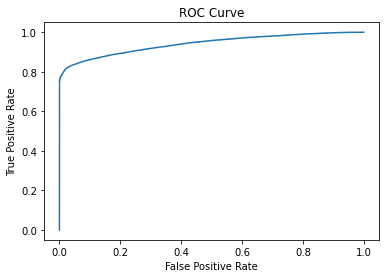

In [14]:
# Results from GridSearch
print("Average Accuracy: " + str(scores.mean()))
print("Best Params: " + str(grid_search.best_params_))
print("Best Score: " + str(grid_search.best_score_))

# Create confusion matrix 
predictions = grid_search.predict(feature_data)
print("Confusion Matrix:")
print(confusion_matrix(label_data, predictions))

# Calculate precision, recall, and f1-score
precision = precision_score(label_data, predictions, average='binary')
recall = recall_score(label_data, predictions, average='binary')
print("Precision: " + str(precision))
print("Recall: " + str(recall))
f1 = (2 * precision * recall)/(precision + recall)
print("F1-Score: " + str(f1))

# Create ROC curve and calculate AUC score
probabilities = grid_search.predict_proba(feature_data)[:, 1]
fpr, tpr, thresholds = roc_curve(label_data, probabilities)
auc_score = roc_auc_score(label_data, probabilities)
print("AUC Score:", auc_score)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The optimal configuration of the model consists of one hiddne layer of size 30 using the logistic sigmoid activation function. The model seems to perform well across all values found.

The high accuracy, precision, and recall indicates that the model has a strong capability to correctly predict no injury. The F-1 score, which is also high, supports this conclusion.

To further analyze the model, we can look at the ROC curve and AUC Score of the neural network's performance. The high AUC score of 0.941 means that the model has a very high measure of separability between the classes. This is also visualized through the ROC curve, as there is a significant lift in the true positive rate as the false positive rate remains low. The ROC and AUC help evaluate models even with imabalnced datasets because they focus on the mode's ability to correctly classify positive cases relative to the negative cases instead of just relying on accurracy. Therefore, this model performed very well, and the issue of class imbalance we were seeing throughout the other models is not a problem with this neural network configuration. 

## Model: Unsupervised

### K-Means

We applied K-Means clustering to analyze the structure of our dataset because of its simplicity and efficiency in handling large datasets. Given the relatively high number of features in our dataset, we anticipated that K-Means could reveal distinct patterns or groupings in the data.

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

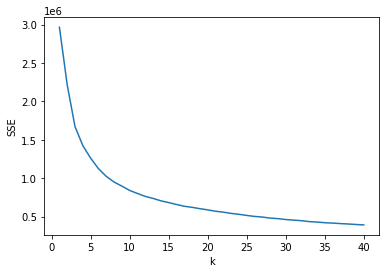

In [61]:
# Find best k
sse = []
k_range = range(1, 41)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feature_data)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 41), sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

We plotted SSE vs. k and applied the elbow method to determine the best k-value. The curve started flattening around k = 5, so we chose 5 as our optimal k-value.

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


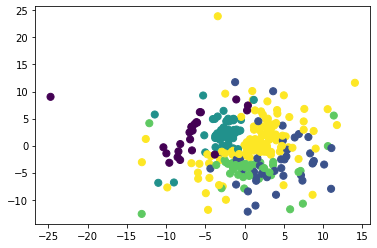

Silhouette Score: 0.12237136529760326


In [65]:
def scatter(data, labels, numPoints = 300):
    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]

    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

# Run k-means with k = 5
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(pca_data)
scatter(pca_data, pd.Series(labels))

# Evaluate via silhouette score
score = silhouette_score(pca_data, labels)
print(f'Silhouette Score: {score}')

We evaluated clustering quality using the silhouette score, which measures how well-separated the clusters are. The score of 0.122 indicates poor cluster separation, where many data points are closer to clusters other than their assigned ones. This result means the clusters are not well-defined. This could be due to a number of factors, including having a bad k-value. Therefore, we decided to try other k-values to see if we could improve the silhouette score.

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


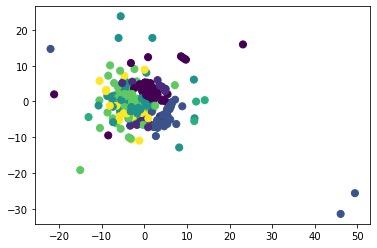

Silhouette Score: 0.13527613709182648


In [71]:
# Run k-means with k = 10
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(pca_data)
scatter(pca_data, pd.Series(labels))

# Evaluate via silhouette score
score = silhouette_score(pca_data, labels)
print(f'Silhouette Score: {score}')

/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/Eshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


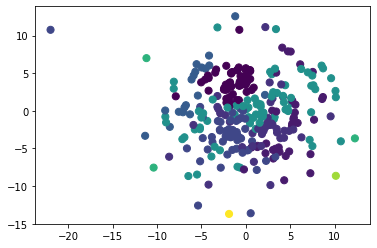

Silhouette Score: 0.1393199466772368


In [72]:
# Run k-means with k = 15
kmeans = KMeans(n_clusters=15)
labels = kmeans.fit_predict(pca_data)
scatter(pca_data, pd.Series(labels))

# Evaluate via silhouette score
score = silhouette_score(pca_data, labels)
print(f'Silhouette Score: {score}')

Although increasing the k-value helped increase the silhouette score a little bit, it did not make a big difference. The silhouette score stayed ~0.13, which is still not very good. This is most likely due to our high dimensionality. Despite running PCA on our data set, we still ended up with 63 dimensions, which is a lot. K-means relies on Euclidean distance to assign points to clusters and calculate centroids. In high-dimensional spaces, Euclidean distance struggles to distinguish between points because they start spreading out more evenly. This makes the points appear roughly equidistant from each other. Additionally, since the volume of the space increases, it becomes harder to detect tight clusters. This makes it difficult for the algorithm to find clear boundaries between clusters. When the distances are similar across points, K-means can assign points to the wrong clusters, leading to poor performance. Additionally, there isn't much natural clustering or separation in the data, which contributes to the low silhouette score.

K-means relies on Euclidean distance to assign points to clusters and calculate centroids. In high-dimensional spaces, Euclidean distance struggles to distinguish between points because they start spreading out more evenly. This makes the points appear roughly equidistant from each other. Additionally, since the volume of the space increases, it becomes harder to detect tight clusters. This makes it difficult for the algorithm to find clear boundaries between clusters. When the distances are similar across points, K-means can assign points to the wrong clusters, leading to poor clustering performance.

### DBSCAN

Given what we looked at from K-means, we found it best to cluster the data into 5 clusteres for good representation. Since that might not make the best sense for this binary classification problem, perhaps we will gain more insight into a density based solution. 

We will create a scatter funciton to create a visualization in 2 dimensions.

In [45]:
def sampledScatter(data, labels):
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

In [5]:
# stratified sampling of the data
def downsample_data(data, labels, num_splits):
    downData = None
    downLabels = None

    # Perhaps consider altering the number of splits
    kfold = StratifiedKFold(n_splits = num_splits, shuffle = False)
    for throwAway_index, subsample_index in kfold.split(data, labels):
        downData = data.iloc[subsample_index]
        downLabels = labels[subsample_index]
        break
    
    print(downData.shape)
    return downData, downLabels

(366, 56)


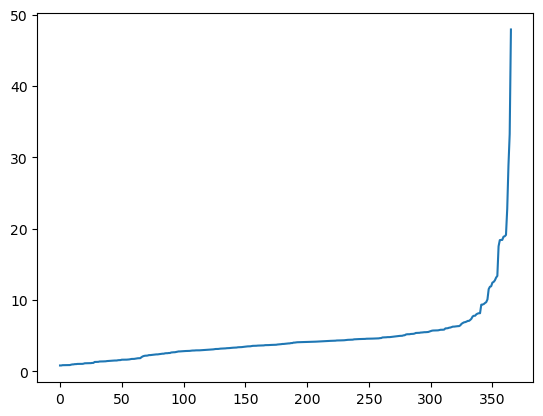

[ 0.80688813  0.80688813  0.8478273   0.85321894  0.85504663  0.85921344
  0.85921344  0.86274137  0.86615954  0.91978384  0.95420209  0.96112132
  0.99671556  0.99671556  1.0239732   1.03164073  1.03164073  1.03164073
  1.03164073  1.05736097  1.1139053   1.11898471  1.12189032  1.12428626
  1.12992256  1.13646631  1.16651158  1.16651158  1.29838414  1.30212543
  1.31063801  1.31595801  1.36314528  1.37089592  1.37089592  1.37747699
  1.37747699  1.39255899  1.42343159  1.43719115  1.43719115  1.45902429
  1.47434278  1.48600701  1.49940499  1.50189571  1.50663073  1.54602556
  1.56284671  1.56515505  1.61575884  1.61575884  1.61783169  1.62510946
  1.62510946  1.63271093  1.6551436   1.68993072  1.72243597  1.72469421
  1.73037863  1.76120771  1.78465223  1.81832697  1.81832697  1.83305942
  1.97913693  2.08152173  2.14315928  2.17789504  2.18357798  2.20492444
  2.2600955   2.2600955   2.28127163  2.30606889  2.33808117  2.34447092
  2.36161731  2.36161731  2.38862699  2.42608542  2

In [47]:
# DBSCAN
# Find optimal eps
downData, downLabels = downsample_data(pca_data, label_data, num_splits=100)

# May need to iterate on n_neighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors.fit(downData)
distances, indices = neighbors.kneighbors(downData, n_neighbors=4)

fourth_neighbor_distance = np.sort(distances[:, -1])
plt.plot(fourth_neighbor_distance)
plt.show()

print(fourth_neighbor_distance)

By looking at the plot, we can estimate that the optimal value for eps would be around 8. As a result, we will choose to complete DBSCAN with an eps of 8 and min_samples of 4. 

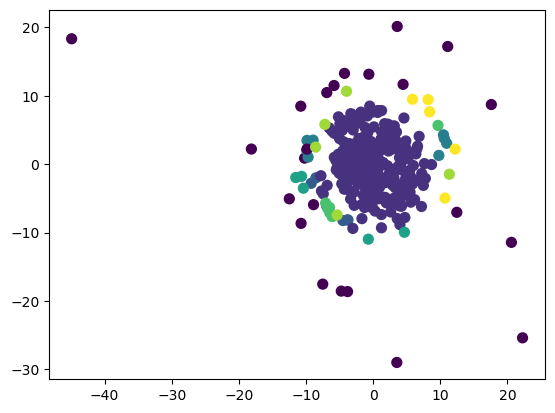

Silhouette Score: 0.2645483542353629
DBCV Score: 0.16258278666993795


In [48]:
# %python -m pip install "git+https://github.com/FelSiq/DBCV"
predicted_labels = DBSCAN(eps = 8, min_samples = 4).fit_predict(downData)

sampledScatter(downData, pd.Series(predicted_labels))

# Evaluate via silhouette score
sil_score = silhouette_score(downData, predicted_labels)
print(f'Silhouette Score: {sil_score}')

dbcv_score = dbcv.dbcv(downData, predicted_labels)
print(f'DBCV Score: {dbcv_score}') 

We evaluated clustering quality using the silhouette score and density-based cluster validation. These measure how well-separated the clusters are and how well low-density clusters are compared to high-desity gaps between clusters, respectfully. 

The silhouetee score of 0.265 indicates little to some cluster separation, where many data points are closer to clusters other than their assigned ones. Moreover, the DBCV score of 0.163 illustrates that certain clusters had lower density than the space between clusters. It's important to note that during iterations with smaller sampling size, we recieved larger values for both scores. This is likely a result of the majority of data points being densly packed together (as seen with the purple points above). This result reflects that the clusters are not well-defined. 

We will use a contingency matrix to complete supervised cluster validation. This will provide more insight as to where our model is going wrong and what we can improve. 

In [43]:
# Assume `predicted_labels` are the cluster labels and `true_labels` are the actual class labels
contingency = contingency_matrix(downLabels, predicted_labels)

# Map clusters to classes using the max overlap for each cluster
cluster_to_class = np.argmax(contingency, axis=0)

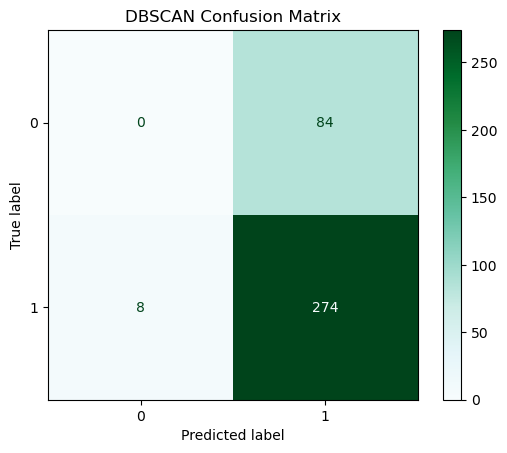

Precision: 0.38268156424581007
Recall: 0.4858156028368794
F-Measure: 0.428125


In [44]:

mapped_labels = np.array([cluster_to_class[cluster] for cluster in predicted_labels])

cm = confusion_matrix(downLabels, mapped_labels)

# Display results from matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.BuGn)  # Use a blue colormap for better visualization
plt.title("DBSCAN Confusion Matrix")
plt.show()

precision = precision_score(downLabels, mapped_labels, average='macro')
recall = recall_score(downLabels, mapped_labels, average='macro')
f_measure = f1_score(downLabels, mapped_labels, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-Measure: {f_measure}")

In [63]:
print(classification_report(downLabels, mapped_labels))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        84
        True       0.77      0.97      0.86       282

    accuracy                           0.75       366
   macro avg       0.38      0.49      0.43       366
weighted avg       0.59      0.75      0.66       366



Before interpreting our confusion matrix, it's important to note that DBSCAN is a density-based clustering algorithm that groups points based on density, and it was evaluated here against binary class labels. A true positive would indicate an accident being correctly identified as 'no injury'.

From the confusion matrix, we can see:

- Injury Precision: 0
- Injury Recall: 0
- Avg Precision: 0.383
- Avg Recall: 0.486
- Avg F-Measure: 0.428

We can see here that given an 'injury' prediction from DBSCAN, it is only 03% likely to be correct. This is problematic in scenarios where false positives (incorrectly predicting an injury) may lead to unnecessary actions, such as dispatching emergency services. The average results is due to the high predicition of no injury while also having many true label points as no injury. Least to say, this current model is problematic.

While DBSCAN performs decent at detecting 'no injury' cases, its ability to predict 'injury' cases requires much more improvement. It will be best to perhaps construct a similar model with more balanced sample data. 

### Hierarchical Clustering

Previous clustering results showed that our models performed best when identifying multiple clusters. However, since we are addressing a binary classification problem, utilizing a hierarchical clustering model could help visualize the proximity or separation between these clusters.

In [6]:
# Hierarchical Clustering
# Make sure to pass your dataset into downsample_data() 
# and use the resulting smaller dataset for hierachical clustering
downData, downLabels = downsample_data(pca_data, label_data, num_splits=100)

# Pass the down-sampled dataset into pdist to get your proximity matrix for calculating CPCC
proximity_matrix = pdist(downData)

# the rest of your code goes here
single_hierarchy = linkage(proximity_matrix, 'single')
complete_hierarchy = linkage(proximity_matrix, 'complete')
average_hierarchy = linkage(proximity_matrix, 'average')
centroid_hierarchy = linkage(proximity_matrix, 'centroid')
ward_hierarchy = linkage(proximity_matrix, 'ward')

single_cpcc = cophenet(single_hierarchy, proximity_matrix)
complete_cpcc = cophenet(complete_hierarchy, proximity_matrix)
average_cpcc = cophenet(average_hierarchy, proximity_matrix)
centroid_cpcc = cophenet(centroid_hierarchy, proximity_matrix)
ward_cpcc = cophenet(ward_hierarchy, proximity_matrix)

print(single_cpcc[0])
print(complete_cpcc[0])
print(average_cpcc[0])
print(centroid_cpcc[0])
print(ward_cpcc[0])


(366, 56)
0.9667331432083209
0.9569471412111693
0.9774733384528673
0.9726075623574766
0.3954551706611284


In order to figure out which proximity function to use, we computed the cophenetic correlation coefficient for multiple proximity functions. This was done by using the proximity matrix and clustrings of the downsampled data. The average linkage method worked the best. Thus, let' create a dendrogram to better visualize this clustering.

{'icoord': [[55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [115.0, 115.0, 125.0, 125.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [205.0, 205.0, 215.0, 215.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [210.0, 210.0, 232.5, 232.5],
  [195.0, 195.0, 221.25, 221.25],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [265.0, 265.0, 282.5, 282.5],
  [255.0, 255.0, 273.75, 273.75],
  [325.0, 325.0, 335.0, 335.0],
  [315.0, 315.0, 330.0, 330.0],
  [345.0, 345.0, 355.0, 355.0],
  [375.0, 375.0, 385.0, 385.0],
  [365.0, 365.0, 380.0, 380.0],
  [350.0, 350.0, 372.5, 372.5],
  [322.5, 322.5, 361.25, 361.25],
  [395.0, 395.0, 405.0, 405.0],
  [445.0, 445.0, 455.0, 455.0],
  [435.0, 435.0, 450.0, 450.0],
  [425.0, 425.0, 442.5, 442.5],
  [415.0, 415.0, 433.75, 433.75],
  [475.0, 475.0, 485.0, 485.0],
  [515

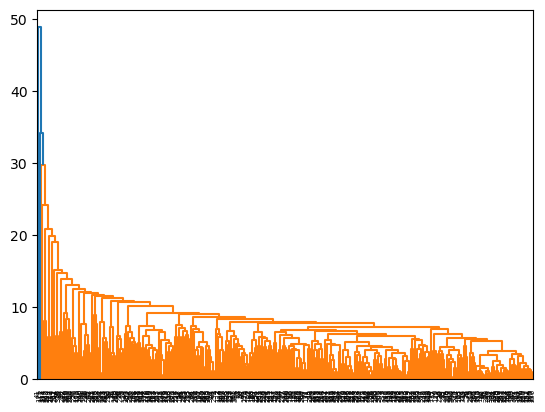

In [2]:
dendrogram(average_hierarchy)

The dendrogram presents multiple clusters close to each other and then an perceived exponential rise in the distance between clusters.  Let's now try hierarchal clustering while limiting our number of clusters to better analyze the clustering. 

In [45]:
# Extract clusters with 5 groups
num_clusters1 = 5
num_clusters2 = 10
num_clusters3 = 15
cluster_labels1 = fcluster(average_hierarchy, t=num_clusters1, criterion='maxclust')
cluster_labels2 = fcluster(average_hierarchy, t=num_clusters2, criterion='maxclust')
cluster_labels3 = fcluster(average_hierarchy, t=num_clusters3, criterion='maxclust')

In [46]:
# Calculate the silhouette score
silhouette_avg1 = silhouette_score(downData, cluster_labels1)
silhouette_values1 = silhouette_samples(downData, cluster_labels1)
silhouette_avg2 = silhouette_score(downData, cluster_labels2)
silhouette_values2 = silhouette_samples(downData, cluster_labels2)
silhouette_avg3 = silhouette_score(downData, cluster_labels3)
silhouette_values3 = silhouette_samples(downData, cluster_labels3)

print(f"Average Silhouette Score (5 clusters): {silhouette_avg1}")
print(f"Average Silhouette Score (10 clusters): {silhouette_avg2}")
print(f"Average Silhouette Score (15 clusters): {silhouette_avg3}")

Average Silhouette Score (5 clusters): 0.6084239123275761
Average Silhouette Score (10 clusters): 0.4097502927398475
Average Silhouette Score (15 clusters): 0.3159976114412559


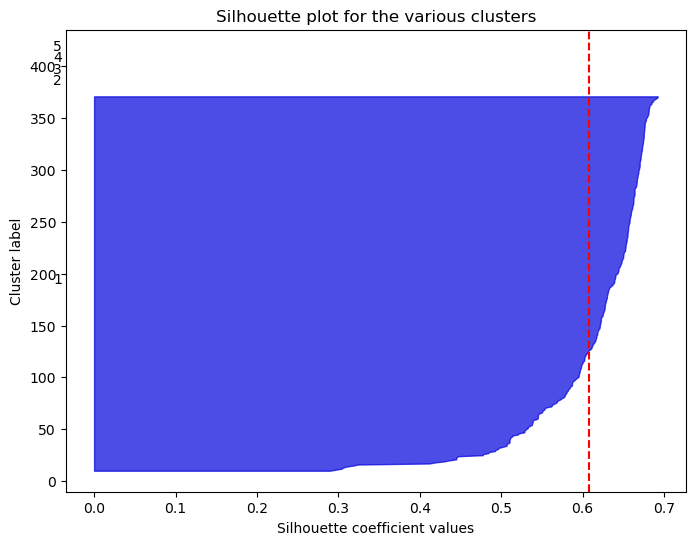

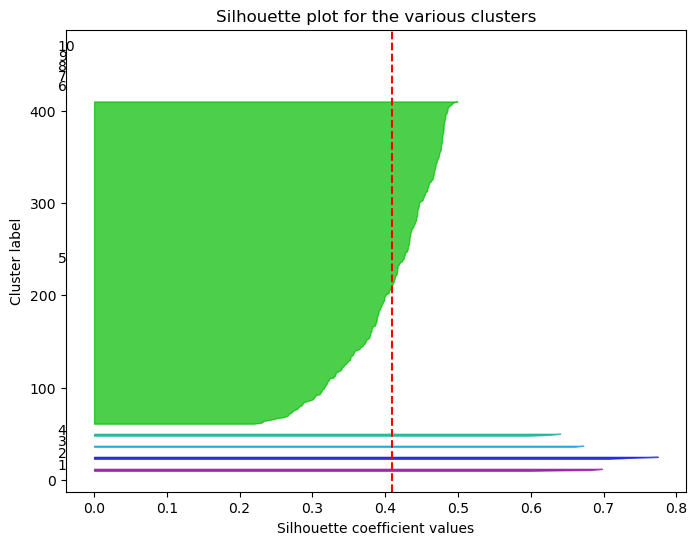

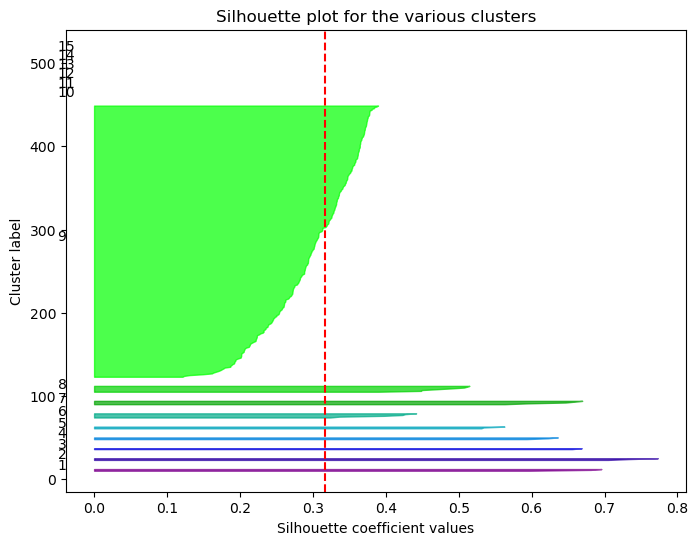

In [47]:
# Silhouette plot
def plot_silhouette(downData, cluster_labels, num_clusters, silhouette_values, silhouette_avg):
    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10  # Starting position for the first cluster
    
    for i in range(1, num_clusters + 1):
        # Aggregate silhouette scores for samples in cluster i
        ith_cluster_silhouette = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette.sort()

        size_cluster = ith_cluster_silhouette.shape[0]
        y_upper = y_lower + size_cluster

        color = plt.cm.nipy_spectral(float(i) / num_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with cluster numbers
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
        y_lower = y_upper + 10  # Add space between clusters

    ax.set_title("Silhouette plot for the various clusters")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")  # Show average silhouette score
    plt.show()

plot_silhouette(downData, cluster_labels1, num_clusters1, silhouette_values1, silhouette_avg1)
plot_silhouette(downData, cluster_labels2, num_clusters2, silhouette_values2, silhouette_avg2)
plot_silhouette(downData, cluster_labels3, num_clusters3, silhouette_values3, silhouette_avg3)

From the following silhouette plots, it is important to note that they have 4-6 cluster that have little to no records. This implies that our data is best represented by a single cluster. However, let's take a look at the plots we created for 5, 10, and 15 clusters. 

The first plot has a relatively large area under the curve, indicating that the silhouette coefficients for most data points are high, generally above 0.5. This suggests that the 5-cluster solution is a decent fit for the data, with the clusters being well-separated and the data points within each cluster being similar to one another.

The second plot has a more complex shape, with some clusters having higher silhouette coefficients than others. The overall silhouette average appears to be lower than in the 5-cluster case, which may indicate that the 10-cluster solution is not as optimal as the 5-cluster solution.

The thrid plot has an even more complex shape, with some clusters having very high silhouette coefficients (close to 1) and others having much lower coefficients. This suggests that the 15-cluster solution may not be an ideal fit for the data, as some of the clusters are likely not well-separated or contain data points that are not very similar to each other.

Overall, the 5-cluster solution appears to be the most optimal, with the highest overall silhouette average and the most consistent cluster separation. The 10-cluster and 15-cluster solutions seem to have more variability and it is likely that our data preferes to be clustered into one big cluster. This is likely due to the fact that many of the records have the rue label of no injury and are clustered quite closely to each other. In general, this provided only a little more insight from DBSCAN, and points us towards creating a more balanced dataset. 

## Conclusion

In our analysis of traffic collision data in Montgomery County, MD, our goal was to accurately predict the injury severity from traffic collisions. We utilized various modeling techniques to approach this problem, each adapted to the characteristics of our dataset. Our analysis included both supervised and unsupervised learning methods to fully explore the underlying patterns and possible predictions within the data.

We started by performing feature selection and engineering. We wanted to refine the dataset by removing irrelevant and overly specific variables, addressing missing values, and reducing dimensionality through manual consolidation and PCA methods. Preprocessing was critical in preparing our data for effective modeling, given the sheer size of the initial dimensions and the significant class imbalance present in our dataset.

### Model Analysis:

- **Decision Trees**, **K-Nearest Neighbors (KNN)**, and **Naive Bayes** initially showed promise in predicting 'no injury' outcomes with high accuracy; however, they struggled with the 'injury' class due to significant class imbalances. KNN using SMOTE addressed many of the issues we were facing with the class imbalance and showed great improvement from the original models trained on unbalanced data.
- **SVM** with the RBF kernel technique was good at handling non-linear data separations but did not show a marked improvement after trying to balance classes using SMOTE. Therefore, class imbalances persisted to be an issue with SVM.
- **Neural Networks**, particularly multi-layer perceptrons, demonstrated a higher performance across metrics, suggesting that neural networks in modeling non-linear interactions are suited to this complex dataset.
- **K-Means Clustering** and other unsupervised methods provided insights into the data structure but were limited by the high-dimensional space and varying densities.
- The **DBSCAN** and **Hierarchical Clustering** models also struggled with the class imbalance issue, with DBSCAN performing poorly in predicting the 'injury' class and Hierarchical Clustering indicating that a single, large cluster may best represent the data.

### Challenges Encountered:

- **Class Imbalance**: This was a recurring challenge across all models. Techniques like SMOTE helped to some extent with improving the representation of “injury” samples but also introduced complexity in model tuning, particularly affecting precision and recall in different ways.
- **High Dimensionality**: Despite efforts to reduce feature dimensions, the curse of dimensionality was evident in clustering analyses where distinguishing between clusters was problematic as displayed in the low silhouette scores achieved in our K-Means model.

### Performance Comparison:

- Models like **Naive Bayes** and **SVM** showed solid accuracy but fell short in dealing with class imbalance. This puts them at a disadvantage in real-world applications where predicting injuries accurately is crucial, similar to the limitations observed in the Hierarchical Clustering models.
- **Neural Networks** showed the best balance between handling high-dimensional data and achieving high accuracy and recall for both classes, making it the most suitable model for this dataset.
- **Decision Trees** performed well primarily due to the class imbalance working in their favor. The model showed high accuracy, particularly in predicting the 'no injury' class, as the imbalance between the classes led to a bias towards this majority class. This bias was evident in the classification report, where precision and recall for the 'injury' class were notably low. While Decision Trees are easy to interpret and efficient in handling simple decision-making tasks, the performance in this case was skewed by the class imbalance.
- **KNN with SMOTE** showed significant improvements over the original KNN model. SMOTE helped balance the class distribution, allowing it to better predict the ‘injury’ class. The model still faced some challenges in terms of precision and recall for the ‘injury’ class, but provided a more balanced prediction than the traditional KNN model. This implication shows the benefits SMOTE can provide to other models, such as DBSCAN. As a result, DBSCAN with SMOTE could potentially create a model that combats KNN’s limitations of density and class imbalance.

In conclusion, our work highlights the importance of rigorous data preprocessing and the selection of appropriate modeling techniques in handling real-world data, which is often messy and imbalanced. What we learned through this project not only contributes to our own knowledge base, but also has practical applications in road safety and emergency response planning. Overall, we learned a lot and appreciated the opportunity to apply what we learned in class to the real world!
